In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import shutil
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# 3d plot
import seaborn as sns
import random 

## Read in 4000 Images for once

In [6]:
# read input images in folder 
source = 'data'
img_path=os.listdir(source)
# Load the pre-trained Inception V3 model to extract features and make predictions
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
model_prediction = InceptionV3(weights='imagenet', pooling='avg')

In [7]:
# Function to Extract features from the images
def feature_and_prediction(direc):
    img_name = []
    features = []
    predictions = []
    for i in tqdm(direc):
        fname= source + '/' +i
        # rescale to 299*299
        img=image.load_img(fname,target_size=(299,299))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)

        feat = model.predict(x)
        pred = model_prediction.predict(x)

        feat = feat.flatten()
        pred = pred.flatten()
        
        features.append(feat)
        predictions.append(pred)
        img_name.append(i)
        
    return features,predictions,img_name

In [8]:
img_features,img_predictions,img_name = feature_and_prediction(img_path)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [06:59<00:00,  9.53it/s]


In [10]:
# create the dataframe including prediction results of each image
image_cluster = pd.DataFrame(img_name,columns=['image'])
image_cluster['predictions'] = img_predictions
image_cluster

,image,predictions
0,10028082.jpg,"[3.4638328e-05, 5.9066595e-05, 2.2137914e-05, ..."
1,10032476.jpg,"[8.9868525e-05, 0.00076959614, 5.3903805e-05, ..."
2,10042477.jpg,"[3.722616e-05, 2.456567e-05, 6.1068626e-05, 3...."
3,10042587.jpg,"[2.4056219e-05, 1.7167677e-05, 0.00013076638, ..."
4,10052485.jpg,"[5.529039e-05, 0.00026725815, 9.057818e-05, 0...."
...,...,...
3995,9974345.jpg,"[0.00021196305, 0.00014072531, 0.0003201498, 0..."
3996,9975476.jpg,"[8.819544e-05, 0.00031179946, 0.00015551253, 0..."
3997,9985021.jpg,"[0.00011913417, 7.9936006e-05, 0.00014606358, ..."
3998,9985792.jpg,"[0.00010264142, 3.804e-05, 0.0002217078, 0.000..."


In [46]:
# # decide the files range 
FF_range = [303, 304, 305, 307, 308, 309, 310, 313, 314, 316, 317, 318, 319, 320]

### Run the Elbow curve to determine the value of K (20)

In [ ]:
# # function returns WSS score for k values from 1 to kmax
# sse = []
# kmax = 25
# for i in range(1,kmax+1): 
#     kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=2000,  n_init=10,random_state=40 )
#     kmeans.fit(img_features)
#     centroids = kmeans.cluster_centers_
#     pred_clusters = kmeans.predict(img_features)
#     curr_sse = 0
    
#     # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
#     for i in range(len(img_features)):
#         curr_center = np.array(centroids[pred_clusters[i]])
#         curr_point = img_features[i]
#         curr_sse += sum((curr_point-curr_center)**2)
        
#     sse.append(curr_sse)

# plt.figure(figsize=(10,7))     
# plt.xticks(fontsize= 20)
# plt.yticks(fontsize= 20)
# plt.plot(range(1,kmax+1),sse)
# plt.title('The Elbow Method Graph',fontsize= 30)
# plt.xlabel('Number of clusters',fontsize= 26)
# plt.ylabel('Within Cluster Sum of Squared Errors',fontsize= 26)
# # plt.savefig("elbow.pdf")
# plt.show()

### Decide K = 20

In [14]:
k = 20

### Feature Reduction: PCA (reduced to top 50 features), then t-SNE (reduced to top 3) 

In [12]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(img_features)
pca_result.shape

(4000, 50)

In [13]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.723657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.729156
[t-SNE] KL divergence after 2000 iterations: 1.628165
t-SNE done! Time elapsed: 72.84523272514343 seconds


In [15]:
kmeans = KMeans(n_clusters=k, init ='k-means++', max_iter=2000,  n_init=10, random_state=40 )
kmeans.fit_predict(tsne_results)
# save the clustered labels
image_cluster["clusterid"] = kmeans.labels_ 
image_cluster['tsne-2d-one'] = tsne_results[:,0]
image_cluster['tsne-2d-two'] = tsne_results[:,1]
image_cluster['tsne-2d-three'] = tsne_results[:,2]
image_cluster

,image,predictions,clusterid,tsne-2d-one,tsne-2d-two,tsne-2d-three
0,10028082.jpg,"[3.4638328e-05, 5.9066595e-05, 2.2137914e-05, ...",17,25.866737,-0.439615,6.521049
1,10032476.jpg,"[8.9868525e-05, 0.00076959614, 5.3903805e-05, ...",15,-8.850790,33.993343,9.264215
2,10042477.jpg,"[3.722616e-05, 2.456567e-05, 6.1068626e-05, 3....",8,3.619394,-24.402906,3.422214
3,10042587.jpg,"[2.4056219e-05, 1.7167677e-05, 0.00013076638, ...",14,-12.783591,-22.607510,-7.740446
4,10052485.jpg,"[5.529039e-05, 0.00026725815, 9.057818e-05, 0....",16,-29.744804,14.169823,7.206219
...,...,...,...,...,...,...
3995,9974345.jpg,"[0.00021196305, 0.00014072531, 0.0003201498, 0...",17,17.742044,-1.659426,16.783302
3996,9975476.jpg,"[8.819544e-05, 0.00031179946, 0.00015551253, 0...",16,-32.481789,13.223985,0.837624
3997,9985021.jpg,"[0.00011913417, 7.9936006e-05, 0.00014606358, ...",6,13.397334,-27.327387,6.315289
3998,9985792.jpg,"[0.00010264142, 3.804e-05, 0.0002217078, 0.000...",6,17.585049,-23.212883,-6.037397


### Visualise the clustering result of inputs

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

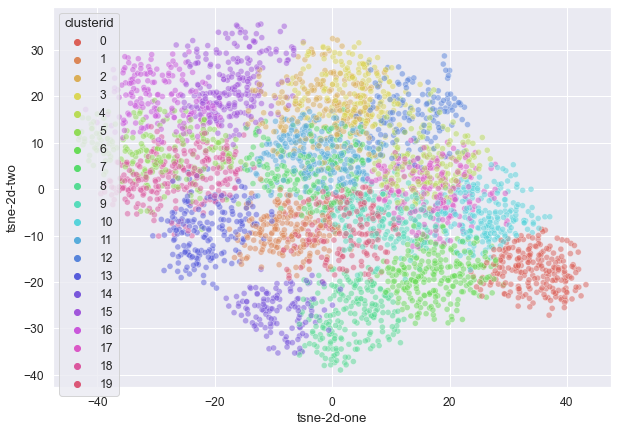

In [17]:
sns.set_style("white")
plt.figure(figsize=(10,7))

sns.set(font_scale=1.1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="clusterid",
    palette=sns.color_palette("hls", 20),
    data=image_cluster,
    legend="full",
    alpha=0.5,
)

# plt.savefig("2dplot.pdf")

In [18]:
mean_predictions = []
for i in range(k):
    c = image_cluster.loc[image_cluster['clusterid'] == i]
    prediction_map = c['predictions'].tolist()
    prediction_map = np.array(prediction_map)
    mean = prediction_map.mean(axis=0)
#     mean[mean < 0.05] = 0
    mean_predictions.append(mean)
    
mean_predictions = np.array(mean_predictions)
mean_predictions.shape

(20, 1000)

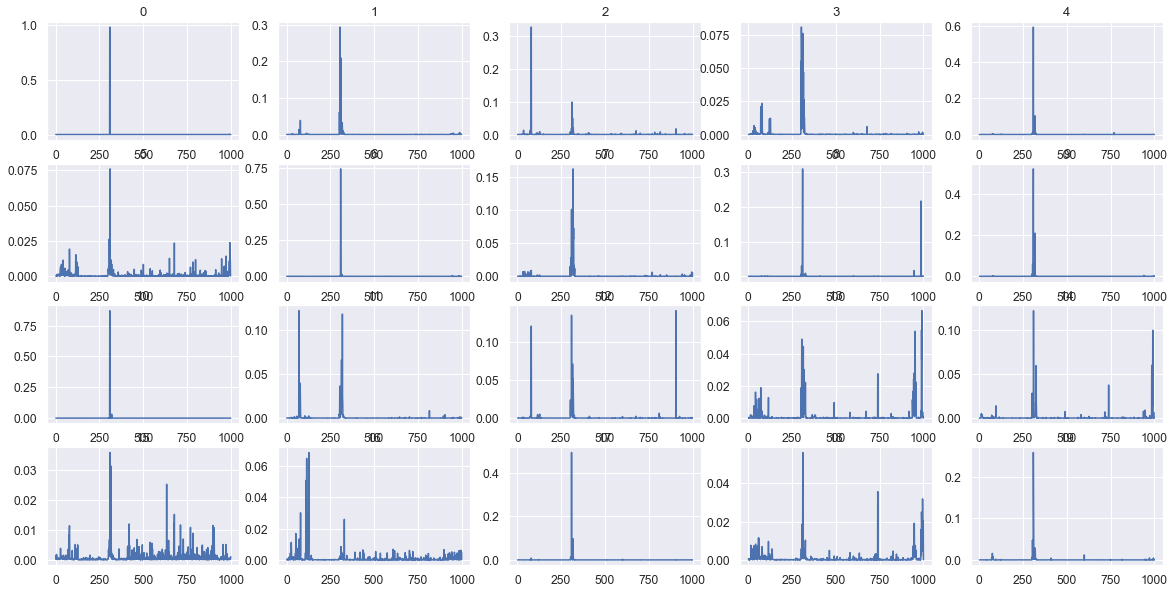

In [19]:
# create a X array to represent 1000 Imagenet classes
X = []
for i in range(1000):
    X.append(i+1)

    
# Visualise the mean probability distribution of each cluster
fig, axs = plt.subplots(4, 5,figsize=(20,10))

matrix = np.zeros((4,5))
values = np.zeros((4,5))

num = 0
for i in range(4):
    for j in range(5):
        axs[i,j].plot(X, mean_predictions[num], label = str(num))
        axs[i,j].set_title(str(num))
        arr = mean_predictions[num]
        max_index = np.argmax(arr, axis=0)
        value = arr[max_index]  
        matrix[i,j] = max_index
        values[i,j] = value
        num += 1
# plt.savefig("tephritid.pdf")

### Moving the images into assigned cluster folders

In [21]:
def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    transferBetweenFolders(source+'/', 
                               dest+'/', 
                               splitRate)


In [22]:
# Made folder to seperate images
for i in range(k):
    if not os.path.exists(str(i)):
        os.mkdir(str(i))

In [41]:
# Transfer all images
for i in range(len(image_cluster)):
    for j in range(k):
        if image_cluster['clusterid'][i]==j:
            shutil.move(os.path.join('data', image_cluster['image'][i]), str(j))

### remove unralated clusters and images

In [42]:
removed = 'Removed/'
kept = 'Keep/'

for i in range(k):
    arr = mean_predictions[i]
    max_index = np.argmax(arr, axis=0)    
    
    # the highest probability score in files range
    files_range = arr[FF_range]
    score = files_range[np.argmax(files_range, axis=0)] 
    
    
    if (max_index not in FF_range) and (score < 0.15):
        transferAllClassBetweenFolders(str(i), removed, 1.0)
    else:     
        images = os.listdir(str(i))
        for name in images:
            p = image_cluster['predictions'].loc[image_cluster['image'] == name].to_list()[0]
            p_range = p[FF_range]
            highest_pro = p_range[np.argmax(p_range, axis=0)] 
            
            if highest_pro < 0.15:
                shutil.move(str(i)+'/'+ name, 
                        removed +'/'+ name)
    transferAllClassBetweenFolders(str(i), kept, 1.0)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!


In [40]:
# transferAllClassBetweenFolders(removed, 'data', 1.0)
# transferAllClassBetweenFolders(kept, 'data', 1.0)